In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys

import numpy as np
import cv2

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117
CUDA is available: True


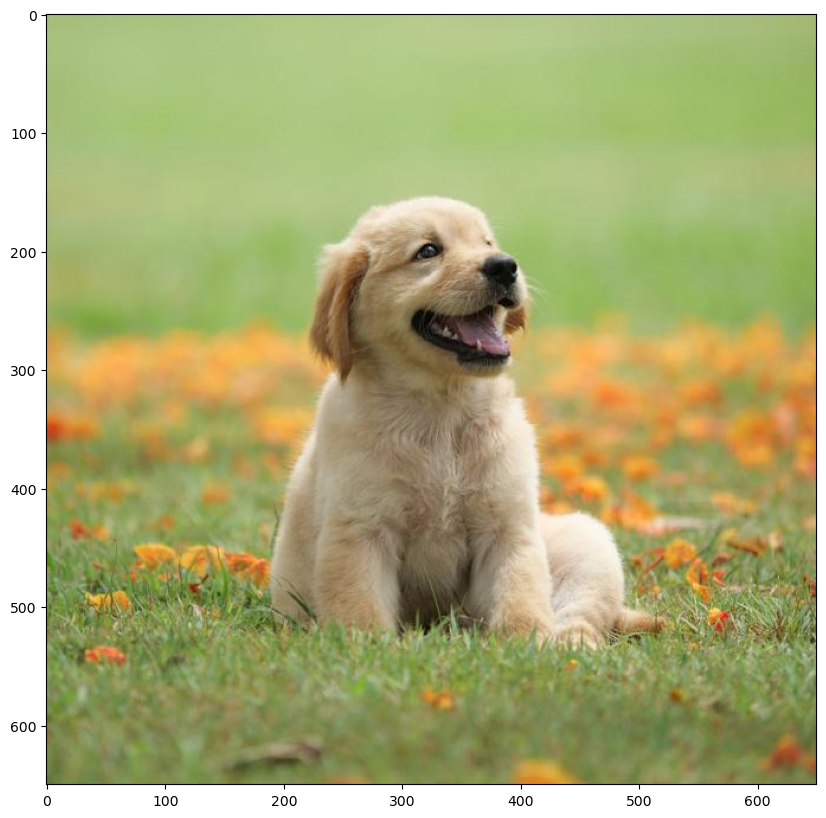

In [3]:
## user defines
imsize = 650  # use small size if no GPU
image_loc = './images/puppy.jpg'
style_loc = './images/picasso.jpg'

image = Image.open(image_loc)
image2 = image.resize((imsize,imsize))
image_loc = '.' + image_loc.split('.')[-2] + '_' + str(imsize) + '.' +image_loc.split('.')[-1]
image2.save(image_loc)

styleim = Image.open(style_loc)
styleim2 = styleim.resize((imsize,imsize))
style_loc = '.' + style_loc.split('.')[-2] + '_' + str(imsize) + '.' +style_loc.split('.')[-1]
styleim2.save(style_loc)

image = cv2.imread(image_loc)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [4]:

# importing the module
import cv2

x_store  = []
y_store  = []
# function to display the coordinates of
# of the points clicked on the image 
def click_event(event, x, y, flags, params):
  
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
  
        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
        x_store.append(x)
        y_store.append(y)
        # displaying the coordinates
        # on the image window
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, str(x) + ',' +
                    str(y), (x,y), font,
                    1, (255, 0, 0), 2)
        cv2.circle(img, (x,y), 3, (0,255,255), -1)
        cv2.imshow('image', img)
  
    # checking for right mouse clicks     
#     if event==cv2.EVENT_RBUTTONDOWN:
  
#         # displaying the coordinates
#         # on the Shell
#         print(x, ' ', y)
  
#         # displaying the coordinates
#         # on the image window
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         b = img[y, x, 0]
#         g = img[y, x, 1]
#         r = img[y, x, 2]
#         cv2.putText(img, str(b) + ',' +
#                     str(g) + ',' + str(r),
#                     (x,y), font, 1,
#                     (255, 255, 0), 2)
#         cv2.circle(img, (x,y), 3, (0,255,255), -1)
#         cv2.imshow('image', img)
  
img = cv2.cvtColor(np.array(image2), cv2.COLOR_RGB2BGR) # convert from PIL image to cv2 image
cv2.imshow('image', img)
cv2.setMouseCallback('image', click_event)
cv2.waitKey(0) # Close window after a key press
cv2.destroyAllWindows()


## Method 2 to get points
# while True:
#     pointx = int(input("Please insert x axis coordinate: "))
#     if pointx > imsize or pointx < 0:
#         print(f"Please insert an appropriate x axis coordinate of value > imsize ({imsize}) \n")
#         continue
#     pointy = int(input("Please insert y axis coordinate: "))
#     if pointy > imsize or pointy < 0:
#         print(f"Please insert an appropriate y axis coordinate of value > imsize ({imsize}) \n")
#         continue
#     break

295   347


In [5]:
y_store

[347]

In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"
device = 'cpu'  ## CUDA memory ran out

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(image)

In [8]:
input_point = np.array([[x_store[-1],y_store[-1]]])
input_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

In [9]:
### if multiple masks

mask_no = 1
minrow,mincol,maxrow,maxcol=len(masks[0]),len(masks[0][0]),-1,-1
shape = masks.shape
rows,cols = shape[1],shape[2]
for row in range(rows):
    for col in range(cols):
        if masks[mask_no-1][row][col] == True:
            if row < minrow:
                minrow = row
            if row > maxrow:
                maxrow = row
            if col < mincol:
                mincol = col
            if col > maxcol:
                maxcol = col

box = [minrow,mincol,maxrow,maxcol]
box = [mincol,minrow,maxcol,maxrow]

Mask 1, Score: 0.986


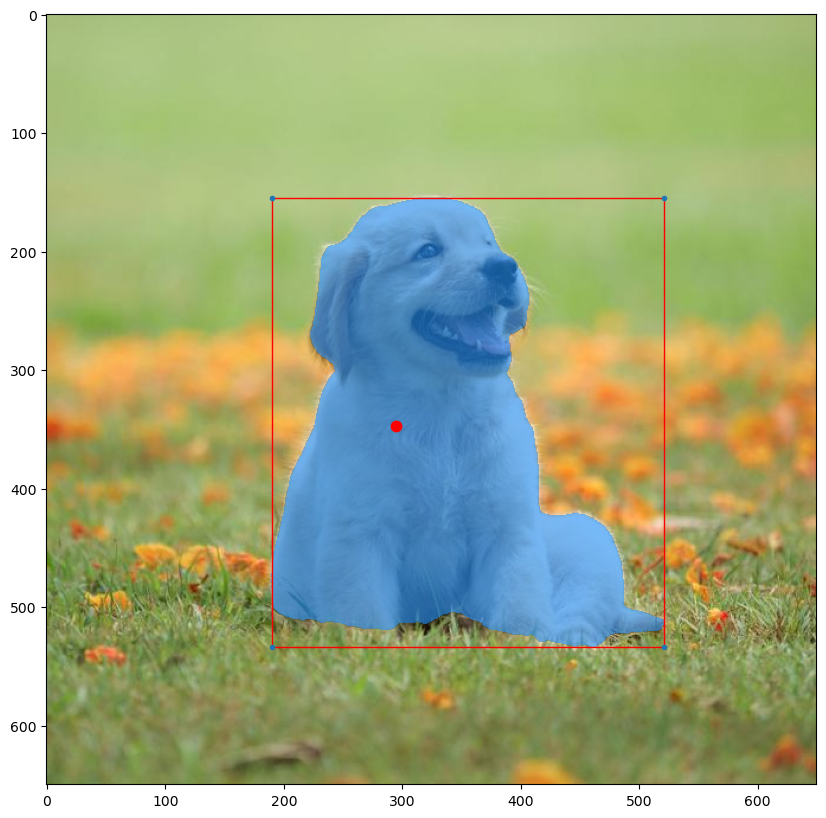

In [47]:
import matplotlib.patches as patches
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    ax = plt.gca()
    show_mask(mask, plt.gca())
    plt.plot([mincol,maxcol,mincol,maxcol],[maxrow,minrow,minrow,maxrow],'.')  # x is col, y is row
    plt.plot(x_store[-1],y_store[-1],'.',color='red',markersize=15)
    rect = patches.Rectangle((mincol, minrow),   maxcol-mincol,maxrow-minrow, linewidth=1, edgecolor='r', facecolor='none')
    # show_box(box, ax)
    ax.add_patch(rect)
    print(f"Mask {i+1}, Score: {score:.3f}")
    plt.axis('on')
    plt.show()  

In [48]:
box = image[minrow:maxrow+1,mincol:maxcol+1,:]
box_im = Image.fromarray(box.astype('uint8'),'RGB') # convert from np array to PIL Image

rows,cols = maxrow-minrow+1,maxcol-mincol+1
styleim2 = styleim.resize((cols,rows))  # resize style im to box image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_default_device(device)

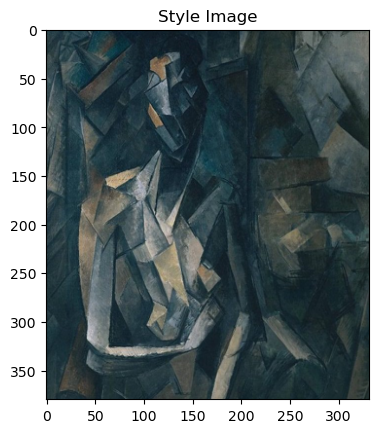

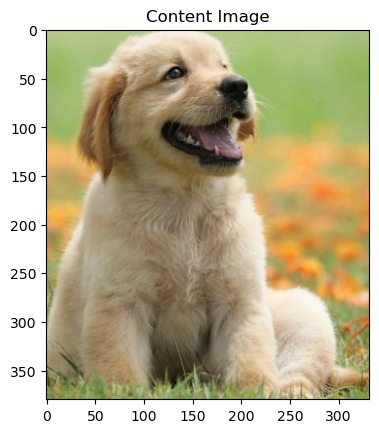

In [50]:
# desired size of the output image
loader = transforms.Compose([  # do not scale
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image):
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader(styleim2)
content_img = image_loader(box_im)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [51]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [52]:
cnn = models.vgg19(pretrained=True).features.eval()

In [53]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [54]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

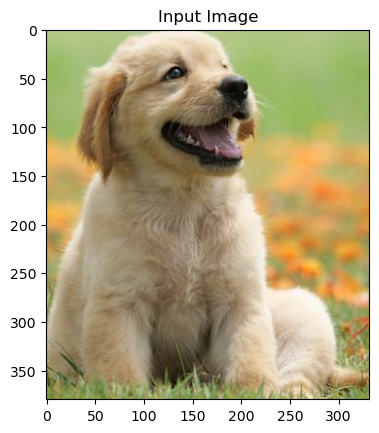

In [55]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# ::
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [56]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 130.491165 Content Loss: 9.751017

run [100]:
Style Loss : 79.111015 Content Loss: 9.288745

run [150]:
Style Loss : 48.604355 Content Loss: 10.413576

run [200]:
Style Loss : 52.828625 Content Loss: 10.670127

run [250]:
Style Loss : 11.868887 Content Loss: 8.945036

run [300]:
Style Loss : 7.572639 Content Loss: 7.255164

run [350]:
Style Loss : 4.722620 Content Loss: 6.313152

run [400]:
Style Loss : 2.662633 Content Loss: 5.768807

run [450]:
Style Loss : 1.443732 Content Loss: 5.377252

run [500]:
Style Loss : 0.839309 Content Loss: 5.043062

run [550]:
Style Loss : 0.568599 Content Loss: 4.779868

run [600]:
Style Loss : 0.443967 Content Loss: 4.579457

run [650]:
Style Loss : 0.398454 Content Loss: 4.420550

run [700]:
Style Loss : 0.377322 Content Loss: 4.303175

run [750]:
Style Loss : 0.365388 Content Loss: 4.224310

run [800]:
Style Loss : 0.357747 Content Loss: 4.159914

run [850]:
Style Loss : 0.351821

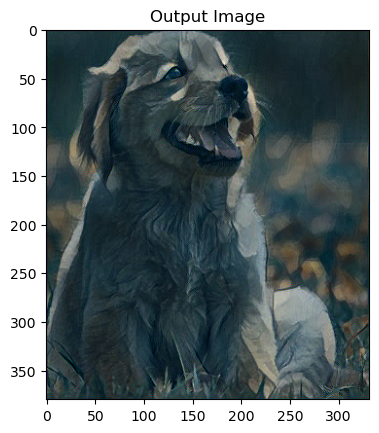

In [57]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps = 1000)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [58]:
tensor = output.cpu().clone()  # we clone the tensor to not do changes on it
tensor_unsq = tensor.squeeze(0)      # remove the fake batch dimension
output_arr = np.asarray(unloader(tensor_unsq))  # convert tensor to array


In [59]:
image[minrow:maxrow+1,mincol:maxcol+1,:] = output_arr

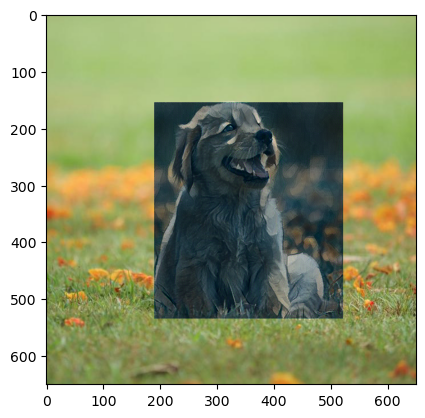

In [63]:
plt.imshow(image)
plt.show()